# Rendu TSA 

Mathieu Laversin 
Alexandra Mille egea
Ryan Pegoud

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('fr.csv')
df.head()

,start,end,load
0,2015-01-01 00:00:00+00:00,2015-01-01 01:00:00+00:00,70929.0
1,2015-01-01 01:00:00+00:00,2015-01-01 02:00:00+00:00,69773.0
2,2015-01-01 02:00:00+00:00,2015-01-01 03:00:00+00:00,66417.0
3,2015-01-01 03:00:00+00:00,2015-01-01 04:00:00+00:00,64182.0
4,2015-01-01 04:00:00+00:00,2015-01-01 05:00:00+00:00,63859.0


# **Descriptive analysis**

In [3]:
df.describe()

,load
count,48870.000000
mean,53556.308267
std,11682.584881
min,29398.000000
25%,44616.000000
50%,51932.000000
75%,61629.750000
max,158000.000000


# **Down sampling**
To study the yearly evolution of the electrical consumption, we can downsample the data to a yearly format

In [4]:
df['start'] = pd.to_datetime(df['start'], format='%Y/%m/%d %H:%M:%S')
df['end'] = pd.to_datetime(df['end'], format='%Y/%m/%d %H:%M:%S')

df.set_index('start', inplace=True)

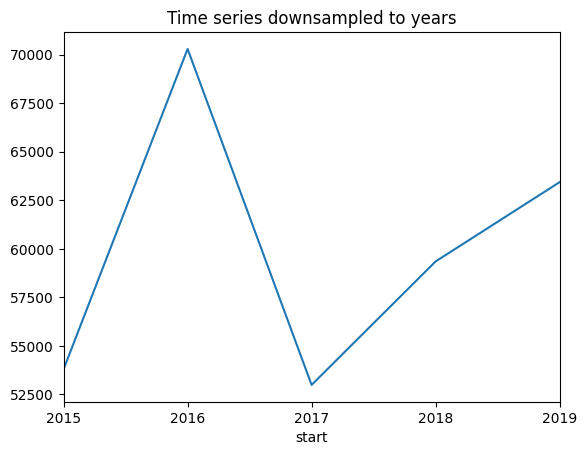

In [5]:
df["load"].asfreq('Y').plot()
plt.title('Time series downsampled to years')
plt.show()

In [6]:
df['year'] = pd.DatetimeIndex(df.index).year
yearly = df.groupby('year').agg('sum')
yearly

C:\Users\ryanp\AppData\Local\Temp\ipykernel_27036\1805939599.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly = df.groupby('year').agg('sum')


,load
year,
2015,470012917.0
2016,477474024.0
2017,475934939.0
2018,470394794.0
2019,467000414.0
2020,256479697.0


# **Monthly Moving Averages**

In statistics, a moving average (rolling average or running average) is a calculation to analyze data points by creating a series of 

averages of different subsets of the full data set.

It is also called a moving mean (MM)[1] or rolling mean and is a type of finite impulse response filter. 
 
Variations include: simple, cumulative, or weighted forms (described below).

In [7]:
df['month'] = pd.DatetimeIndex(df.index).month
df_month_year= df.groupby(['year','month']).agg('mean')
df_month_year

C:\Users\ryanp\AppData\Local\Temp\ipykernel_27036\2700845858.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_month_year= df.groupby(['year','month']).agg('mean')


load
year month              
2015 1      69523.116935
     2      71374.474702
     3      60624.438172
     4      50608.841667
     5      45209.040377
...                  ...
2020 3      55252.318489
     4      42409.579167
     5      40946.911290
     6      42225.624478
     7      44123.798387

[67 rows x 1 columns]

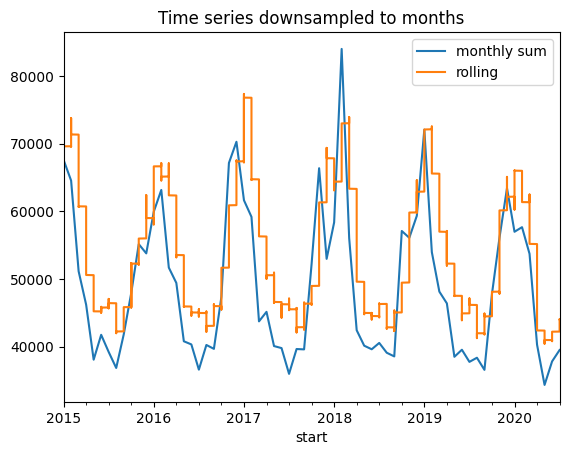

In [8]:
df["load"].asfreq('M').plot(label='monthly sum')

rolling_load = df.load.rolling('30D').mean()
rolling_load.plot(label='rolling')
plt.legend()
plt.title('Time series downsampled to months')
plt.show()

Rolling with a 30 day of window is quite good but we actually lose some informations as we saw on start of 2018

# **Seasonality**

In [9]:
melted_y_m = df.melt(id_vars=['year','month'], value_vars='load').drop('variable',axis=1)
melted_means = melted_y_m.groupby(['year','month']).agg('mean')
melted_means

value
year month              
2015 1      69523.116935
     2      71374.474702
     3      60624.438172
     4      50608.841667
     5      45209.040377
...                  ...
2020 3      55252.318489
     4      42409.579167
     5      40946.911290
     6      42225.624478
     7      44123.798387

[67 rows x 1 columns]

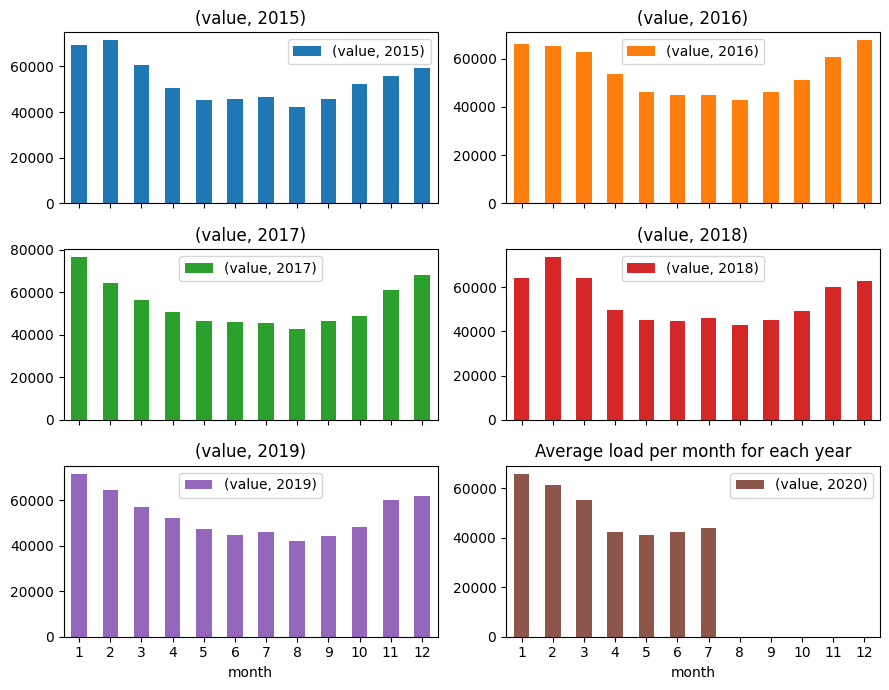

In [10]:
melted_means.unstack(level=0).plot(kind='bar', subplots=True, rot=0, figsize=(9, 7), layout=(3,2))
plt.title('Average load per month for each year')
plt.tight_layout()

This plot helps to visualize a seasonal behaviour in the data.

We will explore the seasonality further later in the notebook.

In [11]:
melted_means['year'] = [melted_means.index[i][0] for i in range(melted_means.shape[0])]

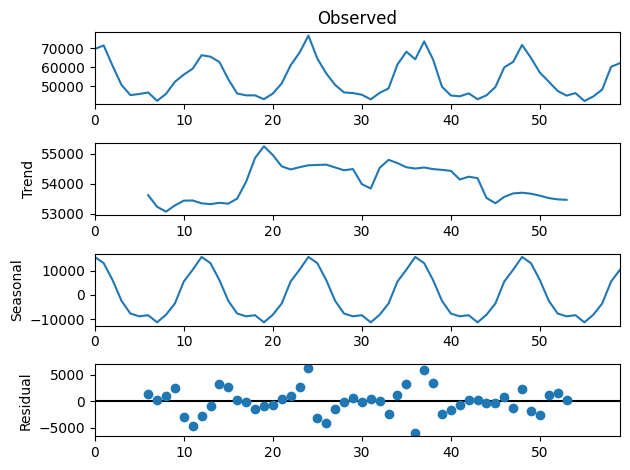

In [12]:
import statsmodels.api as sm

values = melted_means[melted_means['year']<2020]['value'] # monthly means between 2015 and 2019 (2020 is incomplete)
values = np.array(values, dtype=object)
decomposed = sm.tsa.seasonal_decompose(values, period=12) # yearly seasonality
decomposed.plot()
plt.show()

### **Additivity of the trend**

We can see that the trend component varies in a range of 53 000 to 55 000 through the years. 

We can therefore consider that the trend is pseudo-additive (almost linear).

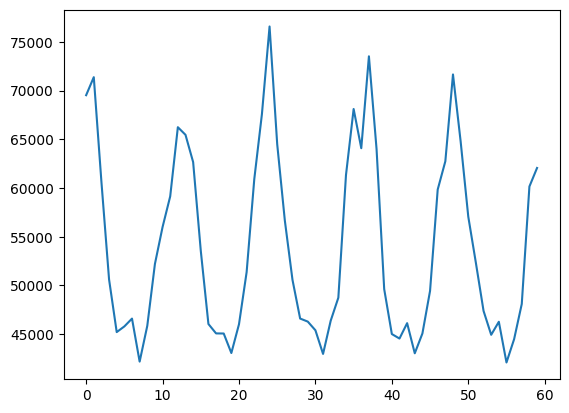

In [13]:
plt.plot(values)

## **Buys-Ballot table**

The buys-ballot table helps to identify a rigid seasonality, here we sort the load by month for each year and try to look for recurrent patterns.

In [14]:
train = melted_means[melted_means['year']<2018]
test = melted_means[melted_means['year'].between(2018,2020)]

In [16]:
list_2015  = np.array(melted_means[melted_means['year'] == 2015].value)

list_2015_BBT = list_2015.argsort()[::-1]

In [54]:
list_2015  = np.array(melted_means[melted_means['year'] == 2015].value)
list_2016  = np.array(melted_means[melted_means['year'] == 2016].value)
list_2017  = np.array(melted_means[melted_means['year'] == 2017].value)
list_2018  = np.array(melted_means[melted_means['year'] == 2018].value)
list_2019  = np.array(melted_means[melted_means['year'] == 2019].value)

list_tot = zip(list_2015,list_2016, list_2017, list_2018,list_2019)

df = pd.DataFrame(list_tot, columns= ['2015', '2016', '2017', '2018','2019'],index=  ['1', '2', '3', '4', '5', '6','7','8', '9', '10', '11', '12'])
df = df.T

#find the index sorted
df_BBT = df.apply(lambda x : np.argsort(x)[::-1], axis = 1)

df_BBT = pd.DataFrame(df_BBT,columns=  ['1', '2', '3', '4', '5', '6','7','8', '9', '10', '11', '12'] )
        
df_BBT

,1,2,3,4,5,6,7,8,9,10,11,12
2015,7,4,5,8,6,3,9,10,11,2,0,1
2016,7,6,5,8,4,9,3,10,2,1,0,11
2017,7,6,5,8,4,9,3,2,10,1,11,0
2018,7,5,4,8,6,9,3,10,11,2,0,1
2019,7,8,5,6,4,9,3,2,10,11,1,0


This table shows that the month with the lowest load is always July whereas December, January and February are the months with the highest load, as we could expect.

There are small variations but we can still conclude that __there is a rigid seasonality__.

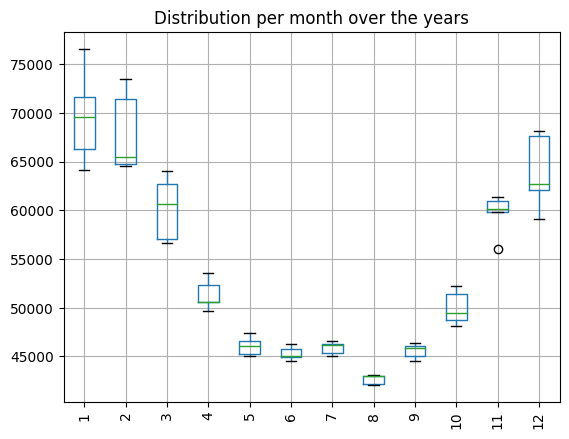

In [53]:
df.boxplot(rot=90)
plt.title("Distribution per month over the years")
plt.show()

We actually see that there is a correct distribution, the data is quite clean. 

There is one outlier in november but actually could be a day with a huge load nothing else.

# **Seasonal coefficients**

Now we can detrend the data and try to estimate the seasonal coefficients.

## **Detrending by differencing**

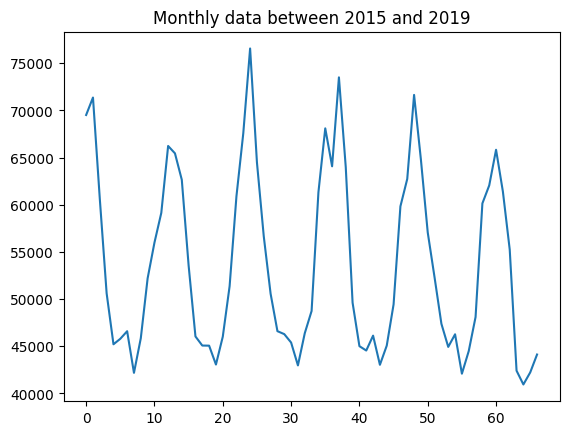

In [60]:
plt.plot(df_month_year.values)
plt.title('Monthly data between 2015 and 2019')
plt.show()

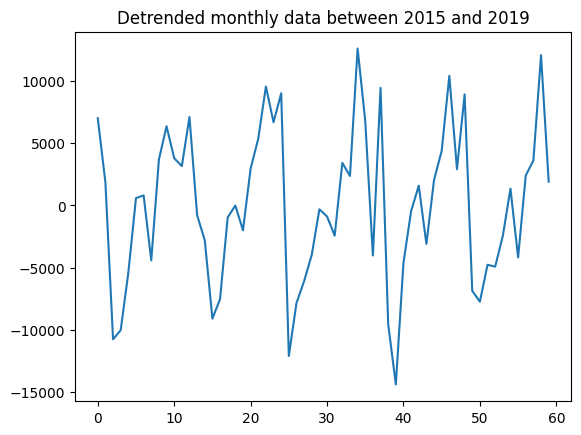

In [62]:
X = df_month_year.values
diff = [X[i] - X[i - 1] for i in range(1,len(X)-7)] # smoothing between 2015 and 2019
diff = np.insert(diff, 0, 7000, 0)
plt.plot(diff)
plt.title('Detrended monthly data between 2015 and 2019')
plt.show()

## Averaging by month

In [56]:
diff = diff.reshape(5, -1)
diff_df = pd.DataFrame(diff)
monthly_mean = diff_df.apply(np.mean, axis=0)
monthly_mean

0     5595.762161
1    -1688.402540
2    -7728.821717
3    -8866.289375
4    -5283.254205
5     -721.893232
6      563.567413
7    -3222.564096
8     2893.481405
9     4409.717571
10    9673.639122
11    4281.464254
dtype: float64

## Standardizing

As the trend is additive, we want the seasonal components to sum up to 0. 

We can substract the mean to every monthly value in order to achieve this.

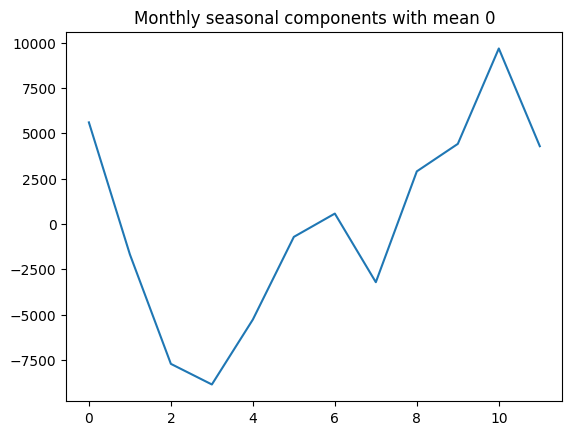

In [63]:
mean_diff = np.mean(monthly_mean)
std_diff = np.std(monthly_mean)

standardized = np.subtract(monthly_mean, mean_diff)

plt.plot(standardized)
plt.title('Monthly seasonal components with mean 0')
plt.show()

In [51]:
standard_df = pd.DataFrame(standardized)
standard_df.T

,0,1,2,3,4,5,6,7,8,9,10,11
0,5603.561598,-1680.603103,-7721.02228,-8858.489938,-5275.454769,-714.093796,571.366849,-3214.76466,2901.280841,4417.517007,9681.438559,4289.263691


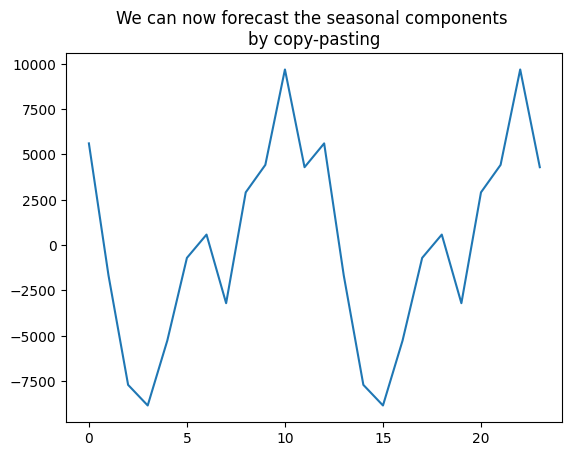

In [72]:
two_years_forecast = pd.concat((standard_df,standard_df)).reset_index(drop=True)
plt.plot(two_years_forecast.values)
plt.title('We can now forecast the seasonal components \nby copy-pasting')
plt.show()